In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools
import copy

### set the seeds and change to current directory + set the output directory

In [2]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [3]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import plotCorr, getPred_fromProb, getMetrics, getCorr, getGroundTruth, getURange
from AnalysisFuncs import getResiduals, plotDistributionProbs, plotCorr_w_Unobs, trainHardPseudo
from AnalysisFuncs import saveFile, loadFile, plotCalibrationPlots

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'ParksInspection', 'New_Dataset')

In [6]:
df_raw = pd.read_csv("./ParksInspection/df_riskprediction_train.csv")
df_raw['INSP_Max_RiskAssment'].min(), df_raw['INSP_Max_RiskAssment'].max()

(0.0, 12.0)

In [7]:
train_second_stage = loadFile(osp.join(processed_data_path,'secondStage'),'train_second_stage.pkl')
test_second_stage = loadFile(osp.join(processed_data_path,'secondStage'), 'test_second_stage.pkl')
test_X = loadFile(osp.join(processed_data_path,'predict_T'), '/test_X.npy')
calibrate_method='sigmoid'
calibrated_p_T = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_T'), '/probs.npy')
calibrated_p_D_T1 = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_D|T'), '/probs.npy')

41941


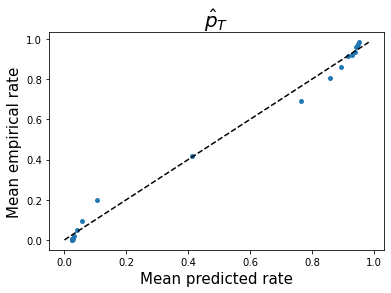

In [8]:
# check that these are indeed the calibrated probabilities 
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_T = loadFile(osp.join(processed_data_path,'predict_T'), '/test_y_T.npy')
plotCalibrationPlots(calibrated_p_T, test_y_T, None, 'T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()
print(len(test_y_T))

20576


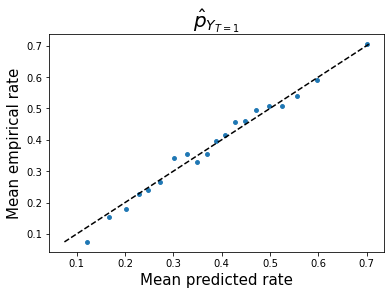

In [9]:
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'), '/test_y_D_given_T.npy')
plotCalibrationPlots(calibrated_p_D_T1[test_y_T==1], test_y_D_given_T, None, 'D|T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()
print(len(test_y_D_given_T))

In [10]:
# load df_cleaned and test_idxs
df_cleaned = loadFile(processed_data_path, 'df_cleaned.csv')
df_sf = loadFile(processed_data_path, 'processed_df.csv')
features = loadFile(processed_data_path, 'features.pkl')
test_idxs = loadFile(processed_data_path, '/test_idxs.npy')
assert len(np.intersect1d(test_idxs[train_second_stage['idxs']], test_idxs[test_second_stage['idxs']]))==0
tr=len(train_second_stage['idxs'])
t=len(test_second_stage['idxs'])
print(f"train %:{tr*100/(tr+t):.2f}, test %:{t*100/(tr+t):.2f}")

/home/rr568/.conda/envs/icu-benchmark/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


train %:50.07, test %:49.93


In [11]:
# load the models
LGBM_T = loadFile(osp.join(processed_data_path, 'secondStage', 'predict_T'),'LGBM_T.pkl')
LGBM_D_given_T = loadFile(osp.join(processed_data_path,'secondStage', 'predict_D_given_T'),'LGBM_D_given_T.pkl')
LGBM_D_and_T =loadFile(osp.join(processed_data_path, 'secondStage', 'predict_D_and_T'),'LGBM_D_and_T.pkl')
LGBM_D_given_T_ipw = loadFile(osp.join(processed_data_path, 'secondStage', 'predict_D_given_T_ipw'),'LGBM_D_given_T_ipw.pkl')
LGBM_D_pseudo = loadFile(osp.join(processed_data_path, 'secondStage', 'predict_D_pseudo'),'LGBM_D_pseudo.pkl')

auc_score:0.946
auc_score:0.946
classification report for model LGBM, task T: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.85     10746
           1       0.84      0.86      0.85     10196

    accuracy                           0.85     20942
   macro avg       0.85      0.85      0.85     20942
weighted avg       0.85      0.85      0.85     20942

auc_score:0.659
auc_score:0.659
classification report for model LGBM, task D|T: 
               precision    recall  f1-score   support

         0.0       0.65      0.64      0.65      6382
         1.0       0.42      0.43      0.42      3814

    accuracy                           0.56     10196
   macro avg       0.53      0.54      0.53     10196
weighted avg       0.56      0.56      0.56     10196

auc_score:0.654
auc_score:0.654
classification report for model LGBM, task D|T_ipw: 
               precision    recall  f1-score   support

         0.0       0.64      0.66      0.65

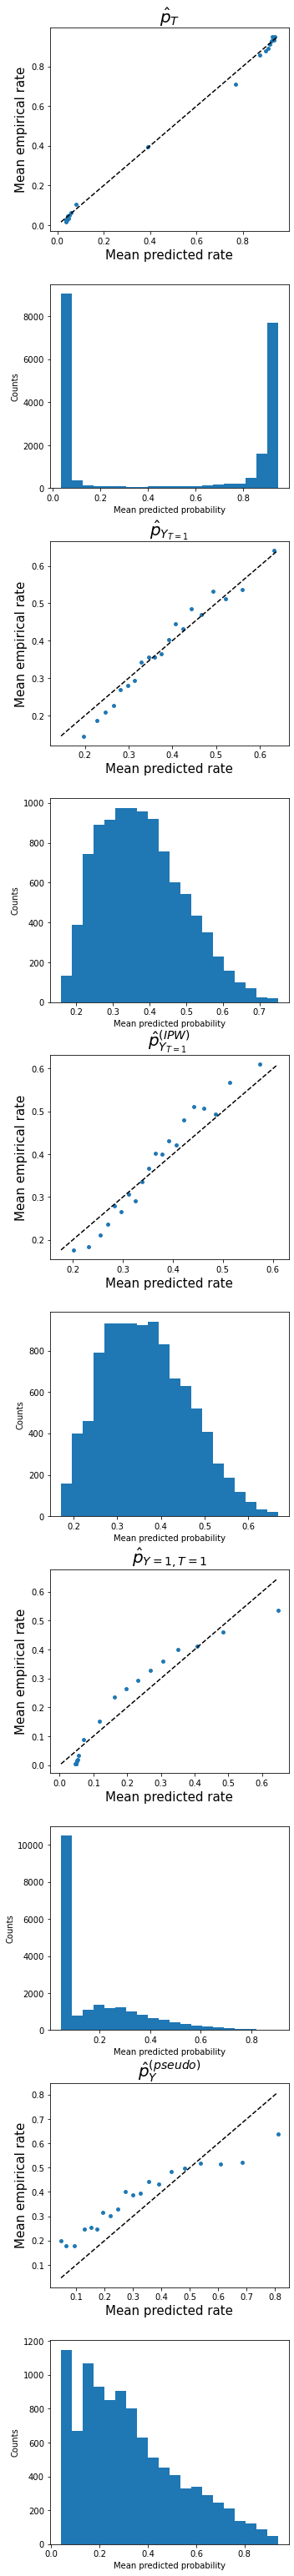

T and D|T probs for model LGBM: (0.4720262965855136, 0.0)
T and D,T probs for model LGBM: (0.7493591539100535, 0.0)
D,T and D|T probs for model LGBM: (0.8285498138423201, 0.0)


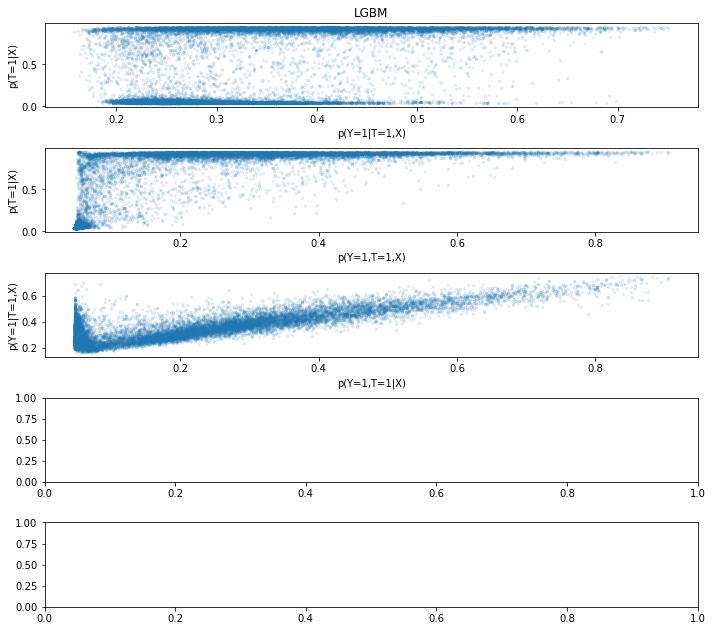

In [12]:
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
clf_list=[LGBM_T, LGBM_D_given_T, LGBM_D_given_T_ipw,
          LGBM_D_and_T, LGBM_D_pseudo]
clf_dict={}
i=0
for t in tasks:
    clf_dict[t]={}
    for m in models:
        clf_dict[t][m]=clf_list[i]
        i+=1
dict_df_labels={}
dict_df_probs={}
dict_df_ids={}
dict_models={}
probs_path=osp.join(processed_data_path, 'secondStage', 'New_Dataset')
alpha=0.1
figsize1=(5,50)
figsize2=(10,10)
df_pp=pd.DataFrame({'AUC' : [],'PR':[],'BalancedAcc':[],'modelName':[],'rowName':[]})
dict_df_labels, dict_df_probs, dict_models, df_pp = getCorr(models, tasks, 
        test_second_stage['X_T'], clf_dict, None, 
        None, dict_df_labels, dict_df_probs, 
        dict_models, df_pp, probs_path, calibrate=False, 
        figsize1=figsize1, figsize2=figsize2, alpha=alpha, test_second_stage=test_second_stage)


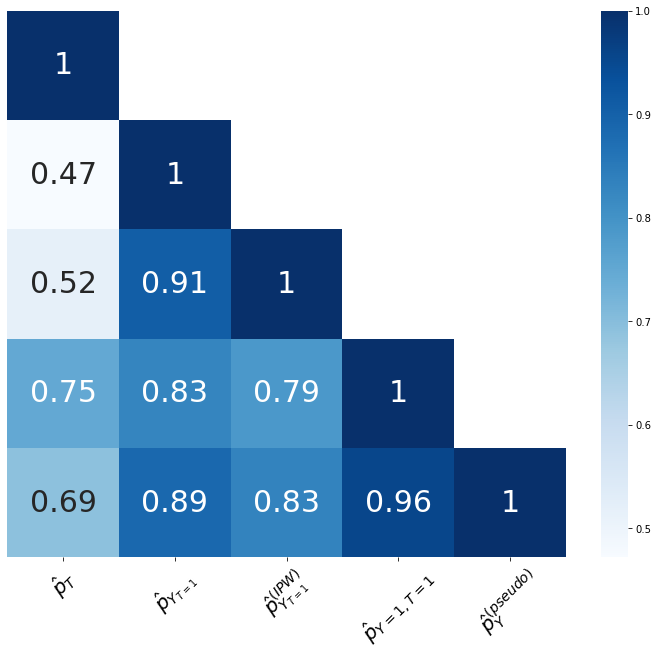

In [13]:
title='correlation matrix'
corr_method="pearson"
figsize=(10, 10)
top_adjust=0.9
title_en=False
plotCorr(models, dict_df_probs, title, corr_method, figsize=figsize, top_adjust=top_adjust,
         title_en=title_en, savefig_path=osp.join(processed_data_path,'secondStage'))

In [14]:
test_X.shape

(41941, 337)

In [15]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/ParksInspection/New_Dataset'

lines did not cross


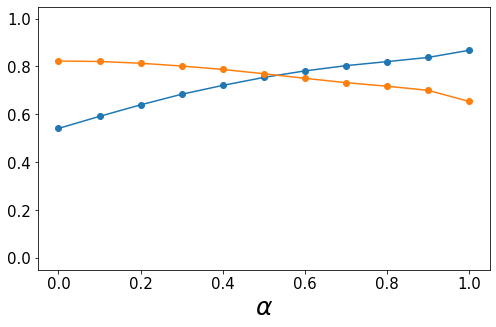

In [22]:
title=r'Inspections Correlation with $p_{Y}$ when $u(x)=\alpha p_{Y_{T=1}}$'
models=['LGBM']
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
#        , 'product_T_D_given_T', 'D_pseudo']
figsize=(7,5)
# figsize=(10,7)
top_adjust=0.9
tasks=['T', 'D|T']
# corr_method=stats.pearsonr
corr_method=stats.spearmanr
title_en=False
loc='lower right'
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, alpha=np.arange(0,1.1,0.1), corr_method=corr_method,
                 figsize=figsize, top_adjust=top_adjust, title_en=title_en, loc=loc,
        calibrated_p_T=calibrated_p_T[test_second_stage['idxs']],
                 calibrated_p_D_T1=calibrated_p_D_T1[test_second_stage['idxs']],
                 savefig_path=osp.join(processed_data_path,'secondStage'))

lines did not cross
[[1.         0.41813787]
 [0.41813787 1.        ]], spearman from lib:SpearmanrResult(correlation=0.4181378651590802, pvalue=0.0), var of D:36549024.15932859, var of T :36549024.158469036
 the point of crossover would be :0.25407250454612873 with std for p_D_T1:0.10643867763594031 and std for p_T:0.41893032788447826


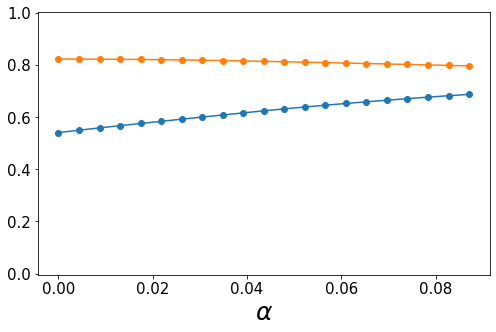

In [23]:
title=r'Inspections Correlation with $p_{Y}$ when $u(x)=\alpha$ is constant'
models=['LGBM']
tasks=['T', 'D|T']
# corr_method=stats.pearsonr
corr_method=stats.spearmanr
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
figsize=(7,5)
# figsize=(10,7)
title_en=False
loc='lower right'
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, corr_method=corr_method,
                 figsize=figsize, title_en=title_en, loc=loc,
        calibrated_p_T=calibrated_p_T[test_second_stage['idxs']],
                 calibrated_p_D_T1=calibrated_p_D_T1[test_second_stage['idxs']],
                savefig_path=osp.join(processed_data_path,'secondStage'))

In [18]:
df_probs_stats=pd.DataFrame({'model' : [],'task':[],'mean':[],'std':[], 'min':[]})
for m in models:
    for t in tasks:
        df_probs_stats=df_probs_stats.append({'model' : m,'task':t,'mean':dict_df_probs[m][t].mean(),
                               'std':dict_df_probs[m][t].std(), 'min':dict_df_probs[m][t].min()},ignore_index=True)
        print(f" mean and std for model {m} and task {t}: {dict_df_probs[m][t].mean():.3f}, {dict_df_probs[m][t].std():.3f}")

 mean and std for model LGBM and task T: 0.492, 0.419
 mean and std for model LGBM and task D|T: 0.337, 0.106


In [19]:
df_probs_stats

,model,task,mean,std,min
0,LGBM,T,0.492255,0.418940,0.035641
1,LGBM,D|T,0.336918,0.106441,0.157973


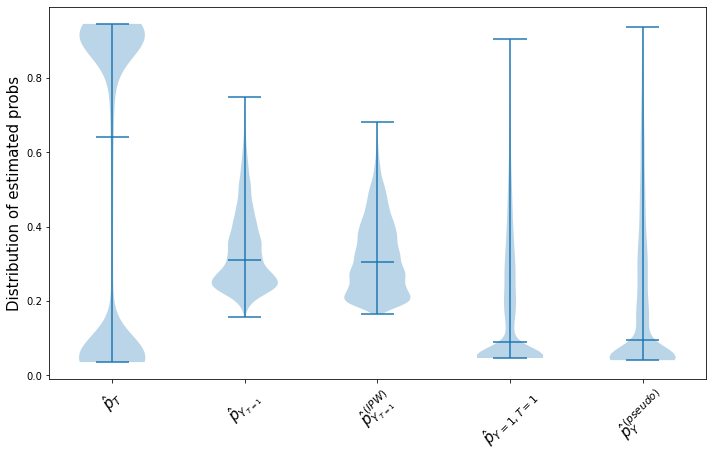

In [20]:
title='Distribution of estimated probs'
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
figsize=(10,7)
plotDistributionProbs(dict_df_probs, models, title, tasks, figsize=figsize)

for model :LGBM


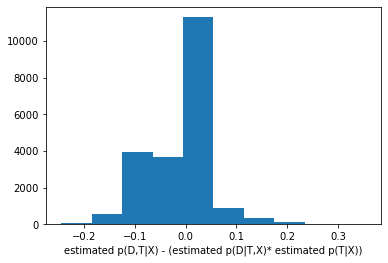

In [21]:
for m in models:
    print(f"for model :{m}")
    getResiduals(dict_df_probs[m]['D_and_T'], dict_df_probs[m]['D|T'], dict_df_probs[m]['T'])